## Analysing the peak results from a hot-deformation experiment

This notebook is used to extract peak results calculated from Continuous-Peak-Fit, to calculate the elastic strain partitioning of two phase materials during hot-deformation.

In [1]:
import pathlib
import re

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.signal import medfilt
import math

import yaml
from typing import Tuple
from typing import List

import continuous_peak_fit_analysis_functions as analysis
import continuous_peak_fit_deformation_functions as deformation
import continuous_peak_fit_sxrd_functions as sxrd

%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/mnt/eps01-rds/Fonseca-Lightform/mbcx9cd4/SXRD_analysis_packages/continuous-peak-fit-analysis/notebooks'

## Load YAML file

The file paths and user inputs for the analysis of the Diamond 2017, Diamond 2021 and DESY 2021 experiments are included in the `yaml` configuration files, to record the inputs of the analysis.

In this case, there are 2x `yaml` files required to analyse the data. 

The **first** yaml file contains information about the .fit files, which can also be used to directly extract the intensities for calculating crystallographic texture.

The **second** yaml file contains additional information about the deformation setup.

The information in the `yaml` files can be accessed like this...

In [3]:
# to load the Diamond 2021 analysis
config_path_texture = "yaml/texture/desy/config_desy_2020_08b.yaml"
config_path_deformation = "yaml/deformation/desy/config_desy_2020_08b.yaml"

config_path_texture = "yaml/texture/desy/config_desy_2020_08b.yaml"
config_path_deformation = "yaml/deformation/desy/config_desy_2020_08b.yaml"

config_texture = analysis.get_config(config_path_texture)
config_deformation = analysis.get_config(config_path_deformation)

## Extracting the single peak profile data from fit files

The single peak profile data (such as the peak position, peak intensity, half-width and pseudo-Voigt weighting) obtained from the Fourier peak analysis in Continuous-Peak-Fit can be extracted from the .fit files using the `read_fit_results` function.

The user inputs required to extract the intensity data are taken directly from the **first** `yaml` configuration file, using the `extract_intensity_input` function. The user inputs include;

- Input and output file paths
- A list of lattice plane peak labels
- Azimuthal data resolution
- Image numbers

*Note, `image_numbers` is returned as retaining information about the different analysis blocks, which is useful to see each stage of the data load, but `image_numbers_sorted` is a single list of all the image_numbers, which is useful for plotting the data.*

In [4]:
experiment_number, input_fit_path, peak_label, data_resolution, \
image_numbers, image_numbers_sorted = deformation.extract_analysis_input(config_path_texture)

The experiment number is:
8

The input path to the fit file is:
../../../SXRD_analysis/desy_2020/experiment{experiment_number:02d}b-deformation/fourier-peak-analysis/Ti64_Rolled_TD_Compress_910C_0-01s-1_Single-Hit_Cool_4Cs-1_new_1-{image_number:05d}.fit

The peak labels for the peaks that are being used are:
['10-10', '0002', '110', '10-11', '10-12', '200', '11-20', '10-13', '20-20', '11-22', '20-21', '0004', '220', '20-22', '10-14', '310', '20-23', '21-30']

The peak labels for the peaks that are NOT being used are:
{'30-31', '211', '222', '20-24', '21-31', '321', '30-30', '21-33', '10-15', '21-32', '11-24'}

The resolution of the data is: 1 degree

The start numbers are: 
[1, 2000, 2800]
The end numbers are: 
[2000, 2800, 4922]
The steps are: 
[50, 1, 50]



In [5]:
peak_position, peak_intensity, peak_halfwidth, peak_PV_weight = analysis.read_fit_results(experiment_number, 
                                                                input_fit_path, peak_label, data_resolution, 
                                                                image_numbers)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/801 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

To make sense of the data and look at the behaviour over time, it makes sense to restructure it. We do this by writing the peak results to new arrays. This will then allow us to plot the behaviour of single lattice plane peaks over time.

In [6]:
peak_position_time, peak_intensity_time, \
peak_halfwidth_time, peak_PV_weight_time \
= deformation.restructure_fit_results(image_numbers, peak_label, data_resolution, 
                                      peak_position, peak_intensity, peak_halfwidth, peak_PV_weight)

The new arrays are structured as nested dictionaries, and the data can be accessed by first defining the lattice plane, followed by the azimuthal angle. For example, using this command:

`print(peak_position_time["10-10"][359])`

the position of the {10-10} lattice plane at an azimuthal angle of ${359^\circ}$ is recorded for each of the diffraction pattern image numbers.

## Plot commands

The following plot commands will be used for subsequent plots.

In [7]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('legend',fontsize=20)
plt.rc('axes',linewidth=2)
plt.rc('xtick.major',width=2,size=10)
plt.rc('xtick.minor', width=2, size=5)
plt.rc('ytick.major',width=2,size=10)
plt.rc('ytick.minor',width=2,size=5)

## Load and Synchronise the thermomechanical data

The thermomechanical test data must be loaded and correctly callibrated to the corresponding synchrotron diffraction pattern image number, to make sense of the effect of hot-deformation on the lattice plane peak changes observed in the synchrotron data.

The parameters for the thermomechanical equipment can be loaded from the **second** yaml file. 

These inputs also include some information about the synchrotron data, such as the acquisition frequency, so that the thermomechanical test data can be adjusted to the correct frequency. 

*Note, if this is the first time loading the data then it is possible to leave out the `start_deformation` and `end_deformation` image numbers in the yaml file, and instead use some initial guesses for `start_deformation_initial` and `end_deformation_initial` which you know will approximately cover the entire deformation region. Then, when you have fully checked the data you can go back and rerun this analysis with the correct definition for the start and end image numbers.*

In [8]:
thermomechanical_equipment, thermomechanical_file_path, start_deformation, \
end_deformation, number_of_frames, acquisition_frequency_sxrd, \
minimum_stress, deform_sequence, filter_equipment, output_file_path \
= deformation.extract_thermomechanical_input(config_path_deformation)

The thermomechanical equipment used for the experiment is:
Dilatometer

The input path for the thermomechanical data is:
../../../SXRD_raw_data/desy_2020/dilatometer_data/Ti64_Rolled_TD_Compress_910C_0.01s-1_Single-Hit_Cool_4Cs-1_ASt_new_DEF1.asc

The start of deformation is number:
2059

The end of deformation is number:
2553

The number of frames has been calculated as:
494

The acquisition frequency of the SXRD pattern images during deformation (in Hz) is:
10

The minimum stress to detect the start of deformation (in MPa) is:
1

The sequence length to detect the start of deformation is:
4

A median filter is being applied to the equipment data, with a value of:
1

The output file path for saving the plots in the notebook is:
../../../SXRD_results/desy_2020/experiment{experiment_number:02d}b-deformation/fourier-peak-analysis-deformation



The next cell uses the `plot_thermomechanical_data` command to calculate the true stress-strain behaviour measured on the thermomechanical equipment, which is slightly adjusted to match the acquisition frequency of the synchrotron diffraction pattern images.

There are currently two types of data that can be loaded:

1. Instron Electro-thermal mechanical tester (ETMT)
2. DIL 805 A/D/T Compression Dilatometer (Dilatometer)

In both cases the data has been reduced to only cover the hot-deformation regime.

For data from the **ETMT**, a separate notebook [sxrd-thermomechanical-test-analysis](https://github.com/LightForm-group/sxrd-thermomechanical-test-analysis) is first needed to calculate the true stress versus true strain behaviour, which is based on a resistance method to calculate the plastic strain. This creates a text file with the converted true stress and true strain, along with other measured parameters such as temperature. This ETMT data has already been reduced, using the notebook, to start at the point of applied load.

For data from the **Dilatometer**, the true stress and true strain data is included in an ascii text file, which can be saved using the accompanying Dilatometer software. In the case of the Dilatometer, the deformation does not start when the deformation file begins recording, and so a stress signal (typically > 1 MPa for more than 4 points) is used to signal the start of deformation. The data is recorded at such a high acquisition frequency that we can expect this corresponds very well with the lattice strain observed from the synchrotron diffraction patterns.

The `plot_thermomechanical_data` function in the `deformation` functions returns arrays of the true stress and true strain at the adjusted acquisition frequency of the recorded diffraction pattern images.

Loading Dilatometer data.
The acquisition frequency of the Dilatometer data is: 232.2986371074521  Hz

The ratio of Dilatometer-to-SXRD acquisition is: 23.22986371074521

The deformation begins at array index: 2465

The deformation ends at array index: 13940

The strain has been shifted by an amount: 0.006997241379310344  to start at zero

Dilatometer unfiltered true stress versus data number:


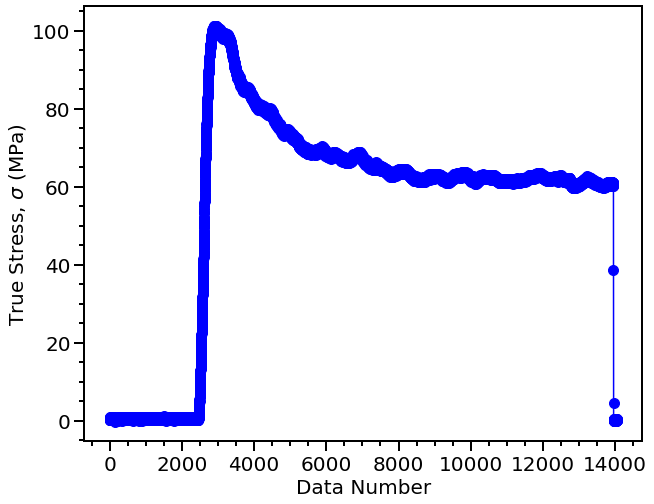

Dilatometer true stress-strain at thermomechanical acquisition frequency:


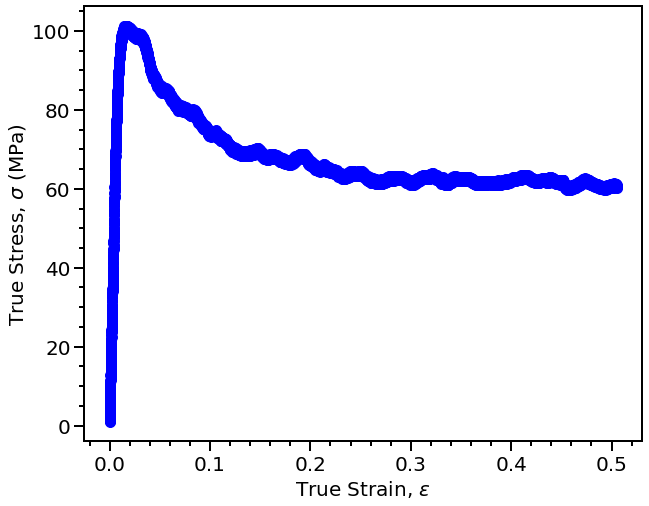

Dilatometer true stress-strain at SXRD frequency:


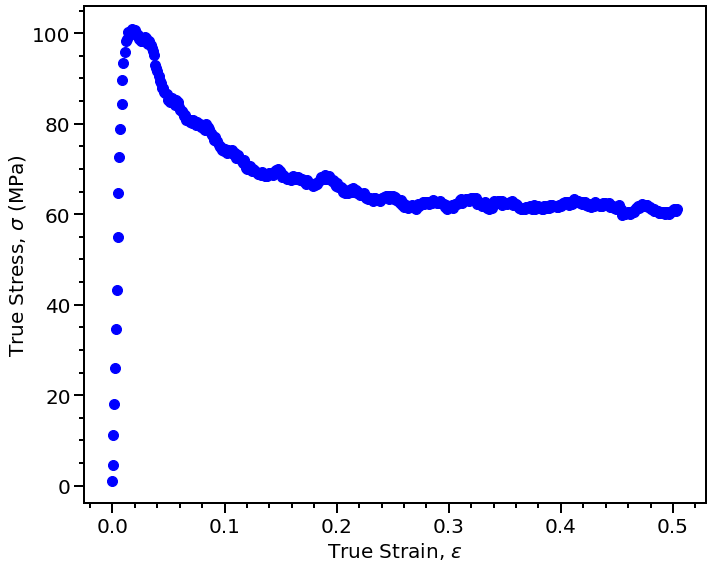

In [9]:
true_stress, true_strain = deformation.plot_thermomechanical_data(thermomechanical_equipment,thermomechanical_file_path, 
                                                            output_file_path, experiment_number,
                                                            minimum_stress, deform_sequence, 
                                                            number_of_frames, acquisition_frequency_sxrd, 
                                                            filter_equipment)

## Load the SXRD inputs

The additional information to analyse the synchrotron data can be loaded from the **second** yaml file using the command below.

Most importantly this defines the azimuthal angle for the loading direction.

In [10]:
beam_energy, azimuth_load_direction, filter_sxrd = sxrd.extract_sxrd_input(config_path_deformation)

The beam energy (in keV) is:
100

The load direction along the azimuthal angle (in degrees) is:
100

A median filter is being applied to the SXRD data, with a value of:
1



## Set the colour and marker scheme

The colour and marker scheme can be set automatically using the `colour_assign` and `marker_assign` functions. These are based on the number of lattice planes included in the analysis.

The current default for the alpha colour type is *viridis*.

The current default for the beta colour type is *PuRd*.

In [11]:
plane_colour = sxrd.colour_assign(peak_label)
plane_marker = sxrd.marker_assign(peak_label)

Plane colours have been defined for  17  lattice planes.

Plane markers have been defined for  17  lattice planes.



This line can be used to reduce the peak labels to plot just the important peaks.

*Note, the beta 211 peak may or may not be resolved, as it is often obscured by the adjacent alpha 10-13 peak.*

In [12]:
peak_label_reduced = ['0002','10-10','11-20','110','200','220']

## Check the start of deformation

### Option 1 - Lattice microstrain

The first option is to look for the characteristic change in lattice microstrain, by alterning the relative start and end points.

The start image number is  2059 , which is the 99 index in the image number list.

The end image number is  2553 , which is the 593 index in the image number list.

Adjust the start and end image number values until you only capture the deforming region, where there will be a characteristic response observed in the lattice microstrain.
0.026243643297612737
0.024272293907485143
0.042033637040405435
0.026705282884765237
0.037802086268945184
0.05344721768382235


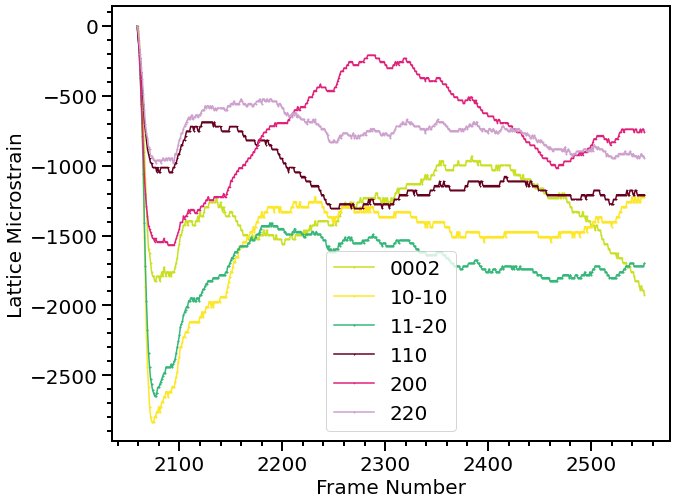

In [13]:
start_number = 2059
end_number = 2553

sxrd.find_start_end_microstrain(start_number, end_number, image_numbers_sorted, peak_label_reduced, 
                           peak_position_time, plane_colour, plane_marker)

### Option 2 - Synchronised thermomechanical analogue output

The second option is to look for the characteristic change in load response recorded by the thermomechanical equipment, by alterning the relative start and end points.

This is only possible if an anologue output from the thermomechanical equipment has already been synchronised with the synchrotron diffraction pattern images. This means a file exists that lists some of the thermomechanical deformation conditions (typically position, temperature and load), along with the corresponding image number. This is usually only possible with ETMT data recorded at Diamond Light Source.

To load the analogue data we need some additional information from the **second** yaml file.

In [14]:
analogue_data_file_path, \
load_conversion, temperature_conversion, position_conversion = deformation.extract_analogue_input(config_path_deformation)

Thermomechanical analogue output has NOT been provided - use OPTION 1 (lattice microstrain) to synchronise data.



Then, alternate the relative start and end points to look for the characteristic change in load response recorded by the termomechanical equipment.

In [15]:
start_number = 2059
end_number = 2553

deformation.plot_analogue_data(analogue_data_file_path, start_number, end_number, 
                               load_conversion, temp_conversion, position_conversion)

NameError: name 'temp_conversion' is not defined

## Analysing the peak changes

### Azimuthal peak position

Check how the minimum and maximum position of the ring changes throughout the test. These plots can be a bit messy as for uniaxial loading conditions the maxmimum and minimum positions of the peaks will alternate at ${180^\circ}$. However, they are useful to check that the the diffraction pattern ring asymmetry, and the individual positions of the peaks, are moving in a way that you'd expect, given the loading conditions.

The start image number is  2059 , which is the 99 index in the image number list.

The end image number is  2553 , which is the 593 index in the image number list.

Variation of azimuthal angle of the maximum position of the ring:


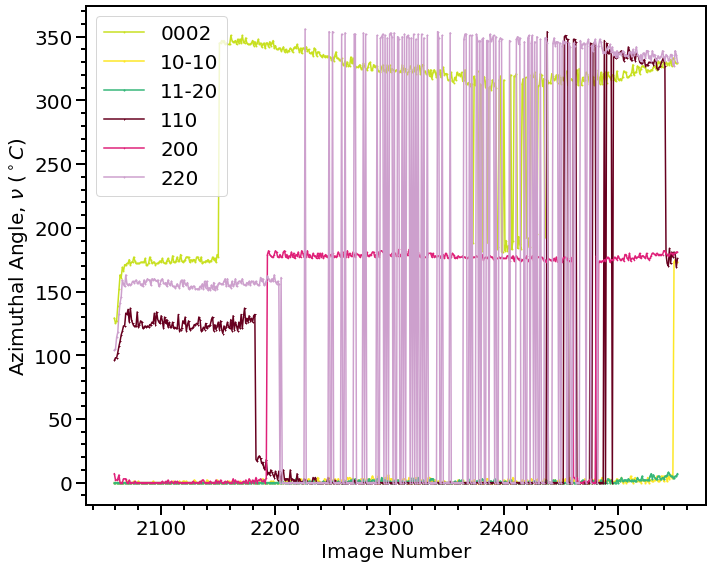

Variation of azimuthal angle of the minimum position of the ring:


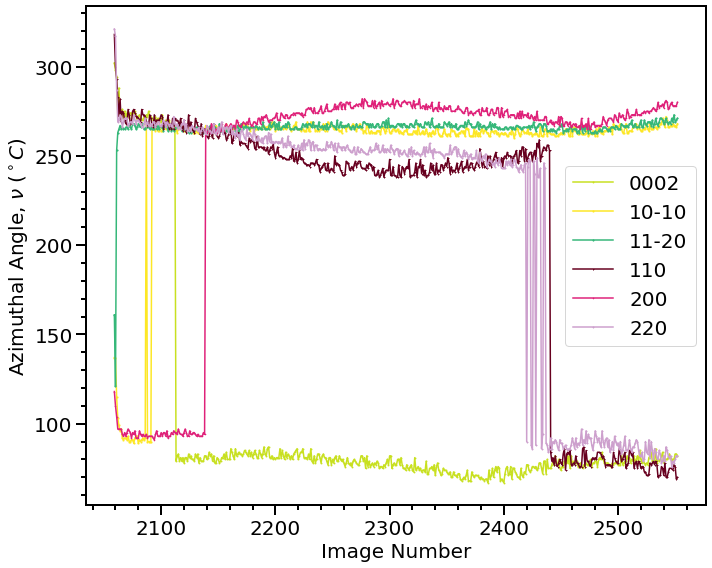

In [20]:
sxrd.follow_azimuth_angle(peak_position_time, image_numbers_sorted,
                          start_number, end_number,
                          peak_label_reduced, data_resolution, 
                          plane_colour, plane_marker, 
                          output_file_path, experiment_number)

### Lattice microstrain behaviour

0.024272293907485143
0.026243643297612737
0.026705282884765237
0.037802086268945184
0.042033637040405435
0.05344721768382235


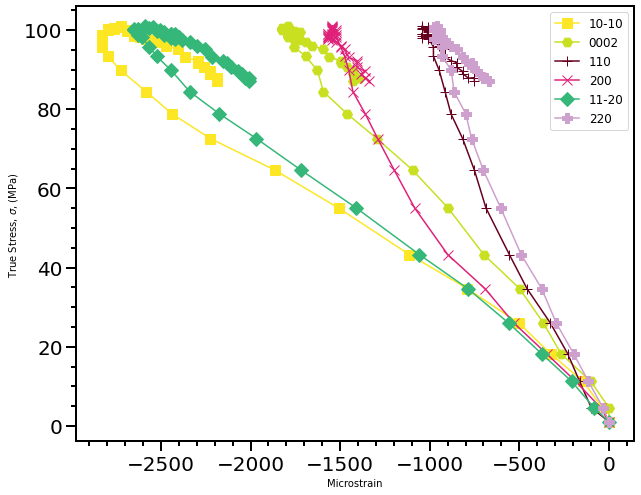

In [188]:
plt.figure(figsize=(10,8))
plt.minorticks_on()

for label in peak_label:
    peak_position_time_array = np.array(peak_position_time[label][0])
    microstrain = calc_strain(peak_position_time_array[99:593])*1e6
#     microstrain = medfilt(microstrain,1)
    plt.plot(microstrain[0:50],true_stress[0:50],marker=plane_marker[label],color=plane_colour[label],markersize=10,label=label)
    plt.legend(fontsize=12)
    plt.ylabel('True Stress, ${\sigma}$, (MPa)')
    plt.xlabel('Microstrain')

    
# plt.tight_layout()
# save_plot_path='results/' + '065' + '_strain_partitioning.eps'
# plt.savefig(save_plot_path, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.02726378824540342
0.02949780968795616
0.0299803932261326
0.042415864146592194
0.04720679294331663
0.05999482037267908


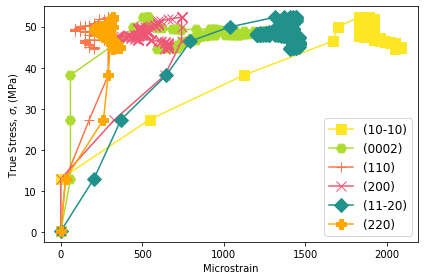

In [56]:
for peak_name in peak_label:
    peak_position_time_array = np.array(peak_position_time[peak_name])
    microstrain = calc_strain(peak_position_time_array[(start_deform_index):(end_deform_index)])*1e6
    microstrain = medfilt(microstrain,15)
    plt.plot(microstrain,true_stress[0:number_deform_points],marker=plane_marker[peak_name],color=plane_colour[peak_name],markersize=10,label=peak_name)
    plt.legend(fontsize=12)
    plt.ylabel('True Stress, ${\sigma}$, (MPa)')
    plt.xlabel('Microstrain')
    
# plt.tight_layout()
# save_plot_path='results/' + '065' + '_strain_partitioning.eps'
# plt.savefig(save_plot_path, format='eps')

### Polar plot of lattice microstrain behaviour